<a href="https://colab.research.google.com/github/bouracha/deeplearning/blob/master/18071890_DL_cw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Coursework 3

------------------------------------------------------

**Student Name:**  <Anthony Bourached> (Student Number: <18071890> )

**Start date:** *26th March 2019*

**Due date:** *29th April 2019, 09:00 am *

------------------------------------------------------


## How to Submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_DL_cw3.ipynb** before the deadline above.

Please produce a **pdf** with all the **results** (tables and plots) as well as the **answers** to the questions below. For this assignment, you don't need to include any of the code in the pdf, but answers to the questions should be self-contained and should not rely on a code reference.  **Page limit: 20 pg.**

### IMPORTANT
Please make sure your submission includes **all results/answers/plots/tables** required for grading. We should not have to re-run your code.

### Credits
A special thank you to Mihaela Rosca, Shakir Mohammend and Andriy Mnih for their help in this coursework.

# Assignment Description 
(Latent Generative Models)


## Topics and optimization techniques covered: 

* Stochastic variational inference
* Amortized variational inference (VAEs)
* Improving amortized variational inference using KL annealing
* Improving amortized variational inference using constraint optimization
* Avoiding latent space distribution matching using GANs


## Tensorflow

**Note: ** Before taking on this assignment you might find it useful to take a look at the `tensorflow_probability` [package](https://www.tensorflow.org/probability), especially if you have not used probability distributions in TensorFlow before. In this assignment we will use only standard probability distribtions (like Gaussian and Bernouli), but worth taking a look on how TF handles in-graph sampling and optimizations involving distributions.

In [0]:
#@title Imports (Do not modify!)

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import tensorflow as tf

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={"lines.linewidth": 2.8}, font_scale=2)
sns.set_style("whitegrid")

# Tensorflow probability utilities
import tensorflow_probability as tfp

tfd = tfp.distributions

import warnings
warnings.filterwarnings('ignore')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
#@title Check you're using the GPU (Expand me for instructions)
# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Helper Functions for visualisation


In [0]:
def gallery(array, ncols=10, rescale=False):
    """Data visualization code."""
    if rescale:
      array = (array + 1.) / 2
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

In [0]:
def show_digits(axis, digits, title=''):
  axis.axis('off')
  ncols = int(np.sqrt(digits.shape[0]))
  axis.imshow(gallery(digits, ncols=ncols).squeeze(axis=2), 
                 cmap='gray')
  axis.set_title(title, fontsize=15)

In [0]:
def show_latent_interpolations(generator, prior, session):
  a = np.linspace(0.0, 1.0, BATCH_SIZE)
  a = np.expand_dims(a, axis=1)

  first_latents = prior.sample()[0]
  second_latents = prior.sample()[0]

  # To ensure that the interpolation is still likely under the Gaussian prior,
  # we use Gaussian interpolation - rather than linear interpolation.
  interpolations =  np.sqrt(a) * first_latents + np.sqrt(1 - a) * second_latents

  ncols = int(np.sqrt(BATCH_SIZE))
  samples_from_interpolations = generator(interpolations)
  samples_from_interpolations_np = sess.run(samples_from_interpolations)
  plt.gray()
  axis = plt.gca()
  show_digits(
     axis, samples_from_interpolations_np, title='Latent space interpolations')

## Hyperparameters (Do not modify!)
These were chosen to work across all models you are going to be training. At times you will need to explore other configuration to answer the questions, but keep this as default -- things should train nicely under these parameters! Check your model and gradients if that is not the case! 

In [0]:
BATCH_SIZE = 64
NUM_LATENTS = 10
TRAINING_STEPS = 10000

In [0]:
tf.reset_default_graph()

## The Data

### Handwritten Digit Recognition Dataset (MNIST)


We will be revisiting the [MNIST digit dataset](https://yann.lecun.com/exdb/mnist/) for this assignment. The setup/processing of the data will be a bit different in this assignment as for training purposes it is sometimes easier to expose the data sampling as an operation in the graph, rather than going through placeholders. This is in general a very useful way of handling data in tensorflow, especially for larger training regimes where 'stepping out' of the graph might be very expensive.

In the following we will walk you through how to get the data into this form. You do not need to worry about it, but it is worth making sure you understand the step, as this is something that might be useful to replicate in the future.
 


In [0]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
print(mnist.train.images.shape)
print(type(mnist.train.images))

(55000, 784)
<type 'numpy.ndarray'>


### Transform the data from numpy arrays to in graph tensors.

This allows us to use TensorFlow datasets, which ensure that a new batch from the data is being fed at each session.run. This means that we do not need to use feed_dicts to feed data to each session.

In [0]:
def make_tf_data_batch(np_data, shuffle=True):  
  # Reshape the data to image size.
  images = np_data.reshape((-1, 28, 28, 1))
  
  # Create the TF dataset.   
  dataset = tf.data.Dataset.from_tensor_slices(images)
  
  # Shuffle and repeat the dataset for training.
  # This is required because we want to do multiple passes through the entire
  # dataset when training.
  if shuffle:
    dataset = dataset.shuffle(100000).repeat()
    
  # Batch the data and return the data batch.
  one_shot_iterator = dataset.batch(BATCH_SIZE).make_one_shot_iterator()
  data_batch = one_shot_iterator.get_next()
  return data_batch

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
print(real_data.shape)

(?, 28, 28, 1)


# Part 1: Latent Variable models and Variational Inference



## T1.1 Stochastic Variational Inference

In this first task we will consider a simple latent variable model $z \rightarrow x$. Your task is to use stochastic variational inference to train a generative model on the MNIST data. For each data point $x_i$, there is a set of variational parameters to be learned. Throughout this assessment, the posterior and the prior will be Normal random variables, with uncorrelated dimensions.


Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)}{\left[ \log p_\theta(x|z)\right]}  - \mathbb{E}_{p^*(x)} \left[KL(q(z|x)||p(z))\right]
\end{equation}

For more information, please check out:
 * http://www.columbia.edu/~jwp2128/Papers/HoffmanBleiWangPaisley2013.pdf

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In the following, I am going to walk you through implementing this model. This will only be done for the first task, but you can use this to structure your code for all of the tasks after this. Also worth taking a look at question 1 at the end of this section before finishing the implementation - this should give you exactly what you have to implement in the update operations and training loop.

### Data variable

We will do multiple session.run to update the variational parameters for one data batch.
To ensure that the same batch is used, we define a variable for the data, and update it after updating the decoder parameters.

In [0]:
data_var = tf.Variable(
      tf.ones(shape=(BATCH_SIZE, 28, 28, 1), dtype=tf.float32), 
      trainable=False)

data_assign_op = tf.assign(data_var, real_data)

Instructions for updating:
Colocations handled automatically by placer.


### Define the decoder

In [0]:
DECODER_VARIABLE_SCOPE = "decoder"

In [0]:
def standard_decoder(z):
  with tf.variable_scope(DECODER_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = tf.layers.dense(z, 7 * 7 * 64, activation=tf.nn.relu)
    h = tf.reshape(h, shape=[BATCH_SIZE, 7, 7, 64])
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=1,
          kernel_size=5,
          strides=2,
          activation=None,  # Do not activate the last layer.
          padding='same')(h)
    return tf.distributions.Bernoulli(h)

In [0]:
decoder = standard_decoder

### Define prior

In [0]:
def multi_normal(loc, log_scale):
  # We model the latent variables as independent
  return tfd.Independent(
      distribution=tfd.Normal(loc=loc, scale=tf.exp(log_scale)),
      reinterpreted_batch_ndims=1)
      
def make_prior():
  # Zero mean, unit variance prior.
  prior_mean = tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)
  prior_log_scale = tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)

  return multi_normal(prior_mean, prior_log_scale)

In [0]:
test = multi_normal([0.0, 0.0], [1.0, 1.0])

In [0]:
test.sample().shape

TensorShape([Dimension(2)])

In [0]:
prior = make_prior()

### Define variational posterior $q(z|x)$

Define this to be a multi-dimensional Gaussian distribution. You can use the helper function above for this, but keep in mind the parameters of this distribution (mean and variance) ought to be trained.

In [0]:
# Build the variational posterior

##################
# YOUR CODE HERE #
##################
mu = tf.Variable(tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32))
Sigma = tf.Variable(tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32))

variational_posterior = multi_normal(mu, Sigma)

### Define and build optimization objective (ELBO)

Putting things together: build the likelihood term and the KL term in the objective in (T1.1) description. 

In [0]:
def bound_terms(data_batch, variational_posterior, decoder_fn):

  ##################
  # YOUR CODE HERE #
  ##################
  
  variational_posterior_sample = variational_posterior.sample()
  likelihood_term = decoder_fn(variational_posterior_sample).log_prob(data_batch)
  print("posterior sample shape", variational_posterior_sample.shape)
  print("likelihood shape", likelihood_term.shape)
  print("decoder output: ", decoder_fn(variational_posterior_sample))
  
  # Reduce mean over the batch dimensions
  likelihood_term = tf.reduce_sum(likelihood_term, [1,2,3])
  print("likelihood shape after reduce sum", likelihood_term.shape)
  likelihood_term = tf.reduce_mean(likelihood_term)
  print("likelihood shape after reduce mean", likelihood_term.shape)

  ##################
  # YOUR CODE HERE #
  ##################

  kl_term = tfd.kl_divergence(variational_posterior, prior, name = 'kl_term')
  
  # Reduce over the batch dimension.
  kl_term = tf.reduce_mean(kl_term)
  
  # Return the terms in the optimization objective in (1.1) description
  return likelihood_term, kl_term

In [0]:
# Maximize the data likelihodd and minimize the KL divergence between the prior and posterior
likelihood_term, kl_term = bound_terms(data_var, variational_posterior, decoder)
train_elbo = likelihood_term - kl_term

##################
# YOUR CODE HERE #
##################
loss =  -train_elbo

posterior sample shape (64, 10)
likelihood shape (64, 28, 28, 1)
decoder output:  tfp.distributions.Bernoulli("decoder_1/Bernoulli/", batch_shape=(64, 28, 28, 1), event_shape=(), dtype=int32)
likelihood shape after reduce sum (64,)
likelihood shape after reduce mean ()


### Build the update operations for the variational and global variables

In [0]:
# Variational variable optimizer
variational_vars_optimizer = tf.train.GradientDescentOptimizer(0.05)

##################
# YOUR CODE HERE #
##################
variational_vars = [mu, Sigma]

# Just to check
print('Variational vars" {}'.format(variational_vars))
variational_vars_update_op = variational_vars_optimizer.minimize(loss, var_list=variational_vars)


# Decoder optimizer
decoder_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)
decoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
print('Decoder vars" {}'.format(decoder_vars))
decoder_update_op = decoder_optimizer.minimize(loss, var_list=decoder_vars)

Variational vars" [<tf.Variable 'Variable_1:0' shape=(64, 10) dtype=float32_ref>, <tf.Variable 'Variable_2:0' shape=(64, 10) dtype=float32_ref>]
Decoder vars" [<tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>, <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose_1/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose_1/bias:0' shape=(1,) dtype=float32_ref>]


In [0]:
# Check trainable variables
tf.trainable_variables()

[<tf.Variable 'Variable_1:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose_1/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose_1/bias:0' shape=(1,) dtype=float32_ref>]

### Training loop

In [0]:
# Number of SVI updates per sample
NUM_SVI_UPDATES = 50

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []

for i in xrange(TRAINING_STEPS):
  
  # Update the data batch.
  sess.run(data_assign_op)

  # Training (put things together based on the operations you've defined before)
  ##################
  # YOUR CODE HERE #
  ##################
  
  for variational_update in range(0, NUM_SVI_UPDATES):
    sess.run(variational_vars_update_op)
  sess.run(decoder_update_op)
  
  
  # Report the loss and the kl once in a while.
  if i % 10 == 0:
    iteration_loss, iteration_kl, iteration_likelihood = sess.run(
          [loss, kl_term, likelihood_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)


Iteration 0. Loss 539.232666016. KL 3.06175679725e-05
Iteration 10. Loss 442.505432129. KL 11.1709709167
Iteration 20. Loss 346.611297607. KL 7.69090127945
Iteration 30. Loss 316.869567871. KL 2.54163551331
Iteration 40. Loss 262.588500977. KL 5.61171388626
Iteration 50. Loss 220.723495483. KL 6.24567890167
Iteration 60. Loss 213.229202271. KL 5.26770305634
Iteration 70. Loss 208.348358154. KL 4.05913972855
Iteration 80. Loss 222.277359009. KL 3.26850414276
Iteration 90. Loss 208.086334229. KL 3.08519005775
Iteration 100. Loss 209.079040527. KL 3.31691479683
Iteration 110. Loss 200.560409546. KL 3.25179672241
Iteration 120. Loss 200.815689087. KL 3.27359890938
Iteration 130. Loss 211.338897705. KL 3.53456902504
Iteration 140. Loss 196.991760254. KL 3.82422065735
Iteration 150. Loss 197.19039917. KL 4.0511713028
Iteration 160. Loss 204.797363281. KL 4.31042289734
Iteration 170. Loss 197.473739624. KL 4.62925052643
Iteration 180. Loss 193.37008667. KL 4.89047622681
Iteration 190. Loss 18

## Results

Let us take a look at the optimization process and the resulting model

### Visualize training process

Plot the loss and KL over the training process (number of iterations)

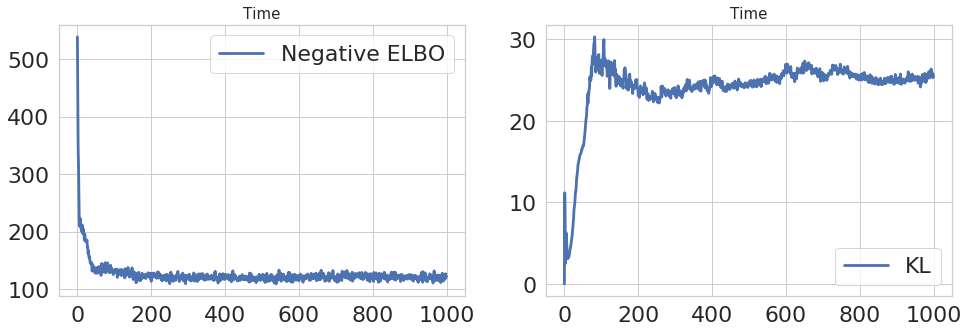

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(2*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

### Generate samples, reconstructions and latent interpolation

In [0]:
# Read data (just sample from the data set)
# real_data_examples

# Note: the reconstructions are only valid after the inner loop optimization has
# been performed.
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
# Sample from the generative model!
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

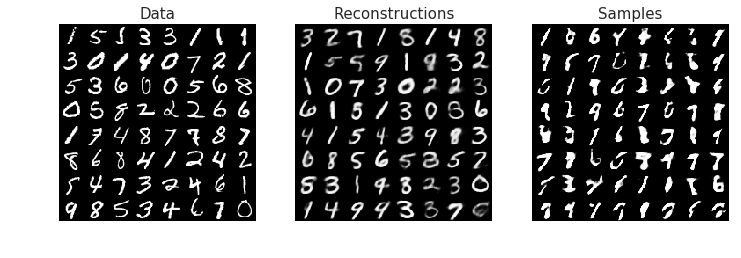

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

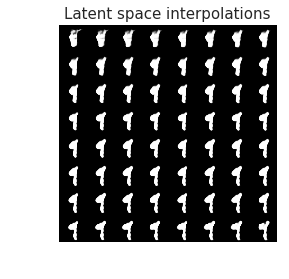

In [0]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q1.1 VI Questions (28 pts):

We going to go through some questions on the model you have just implemented. The first question here could be answered before the implementation and can act as a blue-print for how to do the training. We are going to spend a bit more time on this first method as it is paramount you understand the optimization process here as a lot of the other tasks build on top of this one. 

Whenever a question asks for an effect/behaviour when varying one of the conditions, feel free to experiment. Both theoretical arguments and emperical plots showing the relevant behaviour will be accepted here.

1. **[5 pts]**  Derive the variational ELBO for **one** data point $x$ and explain how one would update the parameters for variational posterior $q_{\phi}(z|x)$, as well as the parameters of the generative distribution $p_{\theta}(x|z)$. Assume a Gaussian prior and a multi-dim Gaussian variational prior, as well as the generative function given  by the decoder in the code above. This is basically outlining the optimization you should be implementing in the **Training loop** section above. 

\begin{equation}
\begin{aligned} \log p(x) &=\log \int p(x, z, \beta) d z d \beta \\ &=\log \int p(x, z, \beta) \frac{q(z, \beta)}{q(z, \beta)} d z d \beta \\ &=\log \left(\mathbb{E}_{q}\left[\frac{p(x, z, \beta)}{q(z, \beta)}\right]\right) \\ & \geq \mathbb{E}_{q}[\log p(x, z, \beta)]-\mathbb{E}_{q}[\log q(z, \beta)]  \text{ using Jenson's inequality} \\
& \triangleq \mathcal{L}(q)\end{aligned}
\end{equation}

where z are the local hidden variables and $\beta$ are global hidden variables, but since we also have the KL divergence:

\begin{equation}
\begin{aligned} \mathrm{KL}(q(z, \beta) \| p(z, \beta | x)) &=\mathrm{E}_{q}[\log q(z, \beta)]-\mathbb{E}_{q}[\log p(z, \beta | x)] \\ &=\mathbb{E}_{q}[\log q(z, \beta)]-\mathbb{E}_{q}[\log p(x, z, \beta)]+\log p(x) \\ &=-L(q)+\mathrm{const.} \end{aligned}
\end{equation}

then we can maximise $\mathcal{L}(q)$ by minimising KL.

2.  **[6 pts] **In the **Build the update operations for the variational and global variables**, I have define two separate optimizers for the two sets of parameters ($\theta$ and $\phi$). 
  * i)  How would you implement this with just one optimizer? (You just need to
explain how you would do it, but not implement).

The reason we have two separate optimizers is two fold: 1 because we want to use stocastic gradient descent for the SVI variables and Adam for the decoder variables and 2 because we want to do multiple SVI updates per decoder update. We could combine these optimizers by specifying these differences within the graph. 

  * ii) What happen if we change the variational variables' optimizer `variational_vars_optimizer` to `tf.train.AdamOptimizer`? (Feel free to experiment and change the learning rate accordingly)
  
  The KL divergence goes to zero staight away not allowing the algorithm to learn how to optimize by maximising the likelihood term. The variational variables are the parameters of a multinomal gaussian distribution and thus their iteration with respect to one sample should be stocastic.
  

3. **[2 pts]** What are the computational considerents to think of when using SVI? What would happen if you would now want to train this SVI model on a big dataset, such as ImageNet? What part of this optimization process is mostly affected and in which way?

Each iteration only takes one datapoint at a time (here we use batch of 64 but this just reduces noise of the sample rather than being like a batch update). Thus optimization on massive datasets such as ImageNet which is >1M images would be very slow.

4. ** [2 pts]**What is the effect of the number of SVI updates on the ELBO and on the KL term?

A too small a number of SVI updates causes the posterior to collapse. This can be seen in the decay of the KL term. If the KL term does not remain sufficiently large the negative ELBO will stop decreasing. 

5. **[3 pts]** What is the effect of the data batch size on the convergence speed compared to the effect of the number of SVI updates? What is the effect of the number of training steps for the decoder compared to the number of SVI steps per decoder update?

If the number of SVI updates per iteration is not sufficiently large then the increasing  


**[10 pts] Model Implementation and Results**

## T1.2 Amortized Variational Inference

**Reminder**: The idea behind amortized inference is to replace the slow iterative optimization process we needed to do in the previous method for each data-point, with a faster non-iterative one.  Check the lecture slides and/or references below for more details.

Thus, instead of learning one set of posterior variables per data point, we can use function approximation to learn the distributional variables. Specifically, the posterior parameters for $x_i$ will be the output of a *learned* function $f_\theta(x_i)$, where $\theta$ are parameters now shared across all data points. Can you think of why this is useful?


<h2 align="center"></h2> <img src="http://elarosca.net/vae.png?format=100w" width=500 >


Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} {\left[ \log p_\theta(x|z) \right]}  - \mathbb{E}_{p^*(x)} \left[ KL(q(z|x)||p(z)) \right]
\end{equation}

For more information, please check out: 
  * https://arxiv.org/abs/1312.6114


**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
print(real_data.shape)

(?, 28, 28, 1)


### Define the encoder

In [0]:
ENCODER_VARIABLE_SCOPE = 'encoder'

In [0]:
def encoder(x):
  with tf.variable_scope(ENCODER_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    
    h = tf.layers.Conv2D(
          filters=8,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(x)
    h = tf.layers.Conv2D(
          filters=16,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=32,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    
    out_shape = 1
    for s in h.shape.as_list()[1:]:
      out_shape*= s
    
    h = tf.reshape(h, shape=[BATCH_SIZE, out_shape])
    mean = tf.layers.dense(h, NUM_LATENTS, activation=None)
    scale = tf.layers.dense(h, NUM_LATENTS, activation=None)
    return multi_normal(loc=mean, log_scale=scale)

### Define the prior

In [0]:
##################
# YOUR CODE HERE #
##################
prior = make_prior()

### Define the variational posterior
**Note**: We no longer have to use a variable to store the data. We will perform one encoder update per decoder update, so it is OK for the data batch to be refreshed at each run.

In [0]:
##################
# YOUR CODE HERE #
##################
variational_posterior = encoder(real_data)

### Define the decoder
We will use the same decoder as in T1.1

In [0]:
decoder = standard_decoder

### Define and build optimization objective (ELBO)

In [0]:
# Maximize the data likelihodd and minimize the KL divergence between the prior 
# and posterior. We use the exact same loss as in the SVI case.

##################
# YOUR CODE HERE #
##################

likelihood_term, kl_term = bound_terms(real_data, variational_posterior, decoder)
train_elbo = likelihood_term - kl_term
loss = -train_elbo

posterior sample shape (64, 10)
likelihood shape (64, 28, 28, 1)
decoder output:  tfp.distributions.Bernoulli("decoder_2/Bernoulli/", batch_shape=(64, 28, 28, 1), event_shape=(), dtype=int32)
likelihood shape after reduce sum (64,)
likelihood shape after reduce mean ()


### Define optimization and the update operations

In [0]:
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)

##################
# YOUR CODE HERE #
##################

decoder_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)

encoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=ENCODER_VARIABLE_SCOPE)
print('Encoder vars" {}'.format(encoder_vars))

decoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
print('Decoder vars" {}'.format(decoder_vars))

update_op = optimizer.minimize(loss, var_list=[encoder_vars, decoder_vars])

Encoder vars" [<tf.Variable 'encoder/conv2d/kernel:0' shape=(5, 5, 1, 8) dtype=float32_ref>, <tf.Variable 'encoder/conv2d/bias:0' shape=(8,) dtype=float32_ref>, <tf.Variable 'encoder/conv2d_1/kernel:0' shape=(5, 5, 8, 16) dtype=float32_ref>, <tf.Variable 'encoder/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'encoder/conv2d_2/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>, <tf.Variable 'encoder/conv2d_2/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'encoder/dense/kernel:0' shape=(1568, 10) dtype=float32_ref>, <tf.Variable 'encoder/dense/bias:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'encoder/dense_1/kernel:0' shape=(1568, 10) dtype=float32_ref>, <tf.Variable 'encoder/dense_1/bias:0' shape=(10,) dtype=float32_ref>]
Decoder vars" [<tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>, <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose/kernel:0' shape=(5, 5, 32, 64) dtype=float32_

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []


for i in xrange(TRAINING_STEPS):
  

  ##################
  # YOUR CODE HERE #
  ##################
  # Training, use update_op 
    
  sess.run(update_op)
  
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl  = sess.run(
          [loss, likelihood_term, kl_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)

Iteration 0. Loss 540.44317627. KL 0.0523548349738
Iteration 100. Loss 210.185333252. KL 4.86784076691
Iteration 200. Loss 181.643432617. KL 8.89294242859
Iteration 300. Loss 137.203887939. KL 14.4222373962
Iteration 400. Loss 125.79095459. KL 16.7971305847
Iteration 500. Loss 133.144454956. KL 17.543926239
Iteration 600. Loss 123.411392212. KL 18.3397712708
Iteration 700. Loss 120.814750671. KL 16.8607254028
Iteration 800. Loss 113.468261719. KL 16.8286247253
Iteration 900. Loss 114.561050415. KL 17.8203659058
Iteration 1000. Loss 118.687759399. KL 18.4056243896
Iteration 1100. Loss 108.538024902. KL 18.2480621338
Iteration 1200. Loss 111.844215393. KL 17.9297428131
Iteration 1300. Loss 116.614105225. KL 18.2195625305
Iteration 1400. Loss 113.540184021. KL 18.4303665161
Iteration 1500. Loss 116.229194641. KL 18.1016464233
Iteration 1600. Loss 117.550750732. KL 18.5357170105
Iteration 1700. Loss 107.530944824. KL 18.2832050323
Iteration 1800. Loss 111.87752533. KL 18.3625717163
Iterati

## Results

Let us take a look at the optimization process and the resulting model


### Visualize the loss in time

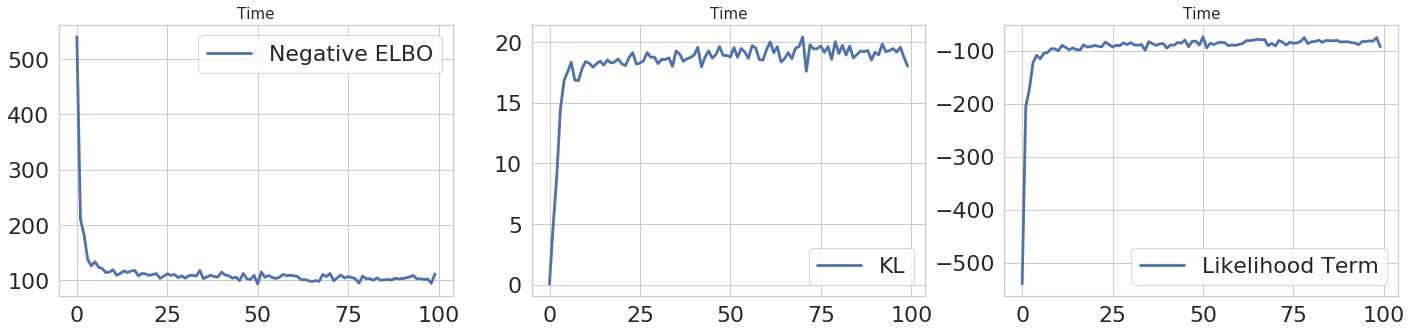

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(likelihood_terms, label='Likelihood Term')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

### Generate samples and latent interpolations

In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

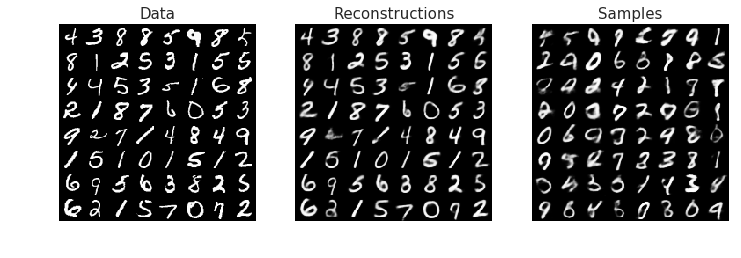

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

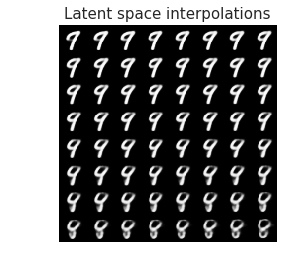

In [0]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q1.2 Questions about Amortized Variational Inference (15 pts)

1. **[5 pts]** What do you notice about amortized variational inference (especially as compared with stochastic variational inference)? 
  * i) Are there any downsides to using the amortized version?
  * ii) What do you observe about sample quality and reconstruction quality? 
  * iii) What do you observe about the ELBO and KL term? \\
(Here, feel free to vary parameters and compare with the T1.1)
2. **[4 pts]** Stochastic and amortized variational inference can be combined, leading to semi-amortized variational inference. Give an instance of an algorithm that would combine these and explain why that would be useful?
3. **[1 pts]** What gradient estimation method is used to compute the gradients with respect to the encoder parameters?

**[5 pts] Model Implementation and Results**

## T1.3 KL annealing

In this section we are going to be looking at the same model as in **T2.1**: same encoder + decoder, prior. But we are going to change slightly the optimization objective as given below.

Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x) \log p_\theta(x|z)}  - \alpha \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z))
\end{equation}

Where **$\alpha$ changes during training, to weigh in the KL term more**. In particular for our problem consider:
\begin{equation}
\alpha = \frac{n_{iter}}{N}
\end{equation}
where $n_{iter}$ is the number of training iterations we are have completed and $N$ is the total number of training iterations `TRAINING_STEPS`.

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)

In [0]:
prior = make_prior()
decoder = standard_decoder
encoder = encoder

##################
# YOUR CODE HERE #
##################
variational_posterior = encoder(real_data)

### Define the KL coefficient $\alpha$ and its update function

In [0]:
##################
# YOUR CODE HERE #
##################
kl_coefficient = tf.Variable(tf.constant(1.0)/TRAINING_STEPS)
kl_step = tf.constant(1.0/TRAINING_STEPS)

update_kl_coeff = tf.assign(kl_coefficient, kl_coefficient + kl_step)

In [0]:
##################
# YOUR CODE HERE #
##################
# Maximize the data likelihodd and minimize the KL divergence between the prior and posterior
likelihood_term, kl_term = bound_terms(real_data, variational_posterior, decoder)
train_elbo = likelihood_term - kl_coefficient * kl_term

loss =  -train_elbo

posterior sample shape (64, 10)
likelihood shape (64, 28, 28, 1)
decoder output:  tfp.distributions.Bernoulli("decoder_2/Bernoulli/", batch_shape=(64, 28, 28, 1), event_shape=(), dtype=int32)
likelihood shape after reduce sum (64,)
likelihood shape after reduce mean ()


In [0]:
# We now perform joint optimization on the encoder and decoder variables.
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)

##################
# YOUR CODE HERE #
##################
encoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=ENCODER_VARIABLE_SCOPE)
print('Encoder vars" {}'.format(encoder_vars))

decoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
print('Decoder vars" {}'.format(decoder_vars))

variables_update_op = optimizer.minimize(loss, var_list=[encoder_vars, decoder_vars])

# Ensure that a variable update is followed by an update in the KL coefficient.
with tf.control_dependencies([variables_update_op]):
  update_op = tf.identity(update_kl_coeff)

Encoder vars" [<tf.Variable 'encoder/conv2d/kernel:0' shape=(5, 5, 1, 8) dtype=float32_ref>, <tf.Variable 'encoder/conv2d/bias:0' shape=(8,) dtype=float32_ref>, <tf.Variable 'encoder/conv2d_1/kernel:0' shape=(5, 5, 8, 16) dtype=float32_ref>, <tf.Variable 'encoder/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'encoder/conv2d_2/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>, <tf.Variable 'encoder/conv2d_2/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'encoder/dense/kernel:0' shape=(1568, 10) dtype=float32_ref>, <tf.Variable 'encoder/dense/bias:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'encoder/dense_1/kernel:0' shape=(1568, 10) dtype=float32_ref>, <tf.Variable 'encoder/dense_1/bias:0' shape=(10,) dtype=float32_ref>]
Decoder vars" [<tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>, <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose/kernel:0' shape=(5, 5, 32, 64) dtype=float32_

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []


for i in xrange(TRAINING_STEPS):
  sess.run(update_op)
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl  = sess.run(
          [loss, likelihood_term, kl_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)

Iteration 0. Loss 538.854187012. KL 0.0401857942343
Iteration 100. Loss 196.53062439. KL 52.7525558472
Iteration 200. Loss 161.689254761. KL 52.7481460571
Iteration 300. Loss 117.359855652. KL 68.5557327271
Iteration 400. Loss 106.196426392. KL 55.6966400146
Iteration 500. Loss 104.79347229. KL 48.1361083984
Iteration 600. Loss 103.79586792. KL 44.9089279175
Iteration 700. Loss 95.7427520752. KL 41.2309341431
Iteration 800. Loss 97.6500854492. KL 38.3099975586
Iteration 900. Loss 95.3079299927. KL 39.2404708862
Iteration 1000. Loss 97.7120819092. KL 35.846786499
Iteration 1100. Loss 89.6634597778. KL 34.811882019
Iteration 1200. Loss 92.830909729. KL 32.0898971558
Iteration 1300. Loss 94.5912399292. KL 34.2768516541
Iteration 1400. Loss 90.5234985352. KL 31.9230308533
Iteration 1500. Loss 88.0244140625. KL 31.0914955139
Iteration 1600. Loss 89.4529647827. KL 29.5734634399
Iteration 1700. Loss 93.9381027222. KL 29.9499816895
Iteration 1800. Loss 87.8928222656. KL 30.3110580444
Iteration

## Results

Let us take a look at the optimization process and the resulting model

### Visualize training process

Plot the loss and KL and likelihood over the training process (number of iterations)

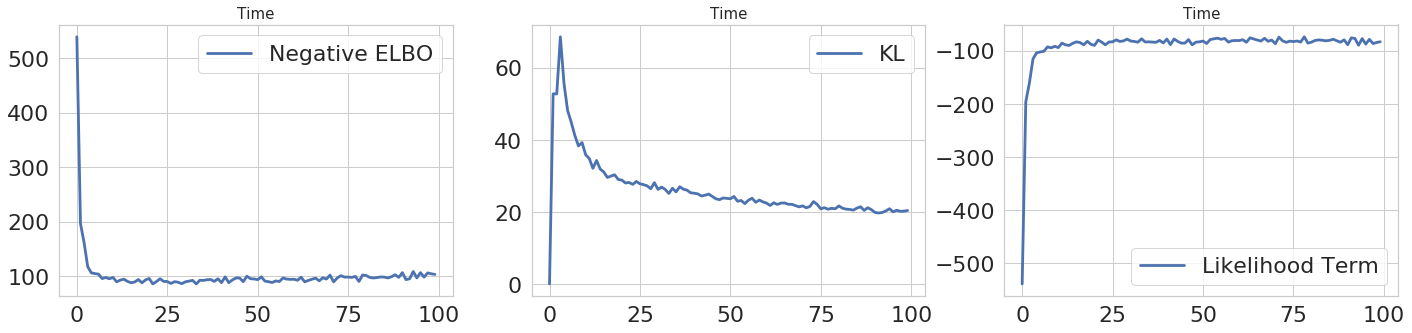

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(likelihood_terms, label='Likelihood Term')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

### Generate samples, reconstructions and latent interpolation

In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

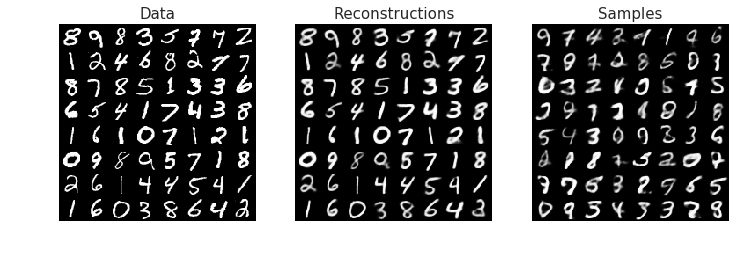

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

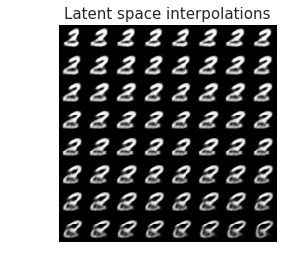

In [0]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q1.3 Questions about KL annealing (15 pts):

1. **[3 pts]** What do you observe about the KL behaviour throughout training as opposed to amortized variational inference without any KL annealing? 
2.  **[1 pts]** How do the samples and reconstruction compare with the previous models?
3.  **[6 pts]** Consider now a schedule where $\alpha$ increases over time -- that is the contribution of the KL diminishes over time. When would that be a useful case? (Think about what this objective corresponds to in the optimization problem).

**[5 pts] Model Implementation and Results**

## T1.4 Constrained optimization

In this next part, instead of using KL annealing, constrained optimization can be used to automatically tuned the relative weight of the likelihood and KL terms. This removes the need to manually create an optimization schedule, which can be problem specific.

The objective now becomes:

\begin{equation}
  \text{minimize } \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z)) \text{ such that }  \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} \left[ {\log p_\theta(x|z)} \right] > \alpha 
\end{equation}

This can be solved using the use of Lagrange multipliers. The objective becomes:

\begin{equation}
  \text{minimize }  \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z)) + \lambda  (\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z)))
\end{equation}


The difference compared to the KL annealing is that:

   * $\lambda$ is a learned parameter - it will be learned using stochastic gradient descent, like the network parameters.  The difference is that the lagrangian has to solve a maximization problem. You can see this intuitively: the gradient with respect to $\lambda$ in the objective above is $\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))$. If $ \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))> 0$, the constraint is not being satisfied, so the value of the lagrangian needs to increase. This will be done by doing gradient ascent, instead of gradient descent. Note that for $\lambda$ to be a valid lagranian in a minimization problem, it has to be positive.
   * The practicioner has to specify the hyperparameter $\alpha$, which determines the reoncstruction quality of the model.
   * the coefficient is in front of the likelihood term, not the KL term. This is mainly for convenience, as it is easier to specify the hyperparameter $\alpha$ for the likelihood (reconstruction loss).


For more assumptions made by this method, see the Karush–Kuhn–Tucker conditions.

For more information, see: 
  * http://bayesiandeeplearning.org/2018/papers/33.pdf

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)

In [0]:
prior = make_prior()
decoder = standard_decoder
encoder = encoder

##################
# YOUR CODE HERE #
##################
variational_posterior = encoder(real_data)

### Define the lagrangian variable $\lambda$.
Unlike in the KL annealing case, we learn the coefficient. Remember that this variable has to be always positive. To ensure this, use `tf.nn.softplus`, Moreover, please initialize the lagrangian such that after the softplus the coefficient is approximately 1. Check emperically that this is true when instantiating the variable.

In [0]:
##################
# YOUR CODE HERE #
##################
lagrangian_var = tf.Variable(1.0)

# Ensure that the lagrangian is positive and has stable dynamics.
lagrangian = tf.nn.softplus(lagrangian_var)

In [0]:
# How good do we want the reconstruction loss to be?
# We can look at previous runs to get an idea what a reasonable value would be.

##################
# YOUR VALUE HERE #
##################
reconstruction_target = tf.constant(100.0)

### Define the loss

In [0]:
##################
# YOUR CODE HERE #
##################

likelihood_term, kl_term = bound_terms(real_data, variational_posterior, decoder)

loss =  kl_term + lagrangian * (reconstruction_target - likelihood_term)

posterior sample shape (64, 10)
likelihood shape (64, 28, 28, 1)
decoder output:  tfp.distributions.Bernoulli("decoder_24/Bernoulli/", batch_shape=(64, 28, 28, 1), event_shape=(), dtype=int32)
likelihood shape after reduce sum (64,)
likelihood shape after reduce mean ()


In [0]:
# Check trainable variables (the lagrangian variable should be in here)
tf.trainable_variables()

[<tf.Variable 'encoder/conv2d/kernel:0' shape=(5, 5, 1, 8) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d/bias:0' shape=(8,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/kernel:0' shape=(5, 5, 8, 16) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'Variable:0' shape=() dtype=float32_ref>,
 <tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose/kernel

In [0]:
lagrangian_optimizer = tf.train.GradientDescentOptimizer(0.001)

##################
# YOUR CODE HERE #
##################

encoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=ENCODER_VARIABLE_SCOPE)
print('Encoder vars" {}'.format(encoder_vars))

decoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
print('Decoder vars" {}'.format(decoder_vars))

autoencoder_variables_update_op = optimizer.minimize(loss, var_list=[encoder_vars, decoder_vars])

# Ensure that a variable update is followed by an update to the Lagrangian.
with tf.control_dependencies([autoencoder_variables_update_op]):
  # Ensure that the lagrangian solves a maximization problem instead of a
  # minimization problem by changing the sign of the loss function.
  update_op = lagrangian_optimizer.minimize(- loss, var_list=[lagrangian_var])

Encoder vars" [<tf.Variable 'encoder/conv2d/kernel:0' shape=(5, 5, 1, 8) dtype=float32_ref>, <tf.Variable 'encoder/conv2d/bias:0' shape=(8,) dtype=float32_ref>, <tf.Variable 'encoder/conv2d_1/kernel:0' shape=(5, 5, 8, 16) dtype=float32_ref>, <tf.Variable 'encoder/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'encoder/conv2d_2/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>, <tf.Variable 'encoder/conv2d_2/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'encoder/dense/kernel:0' shape=(1568, 10) dtype=float32_ref>, <tf.Variable 'encoder/dense/bias:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'encoder/dense_1/kernel:0' shape=(1568, 10) dtype=float32_ref>, <tf.Variable 'encoder/dense_1/bias:0' shape=(10,) dtype=float32_ref>]
Decoder vars" [<tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>, <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose/kernel:0' shape=(5, 5, 32, 64) dtype=float32_

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []
lagrangian_values = []

for i in xrange(TRAINING_STEPS):
  sess.run(update_op)
  
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl, lag_val  = sess.run(
          [loss, likelihood_term, kl_term, lagrangian])
    print('Iteration {}. Loss {}. KL {}. Lagrangian {}'.format(
          i, iteration_loss, iteration_kl, lag_val))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)
    lagrangian_values.append(lag_val)

Iteration 0. Loss 1077.50891113. KL 0.0477716587484. Lagrangian 1.67816281319
Iteration 100. Loss 11348.8779297. KL 31.0048351288. Lagrangian 38.6488647461
Iteration 200. Loss 17780.6679688. KL 57.981174469. Lagrangian 66.9571151733
Iteration 300. Loss 20367.9023438. KL 74.0634536743. Lagrangian 90.9296417236
Iteration 400. Loss 23685.7402344. KL 82.0362091064. Lagrangian 112.404312134
Iteration 500. Loss 26845.7285156. KL 82.4329071045. Lagrangian 132.967727661
Iteration 600. Loss 30668.2578125. KL 80.606086731. Lagrangian 152.952774048
Iteration 700. Loss 33727.5429688. KL 78.8110275269. Lagrangian 172.626022339
Iteration 800. Loss 38248.5546875. KL 73.8397903442. Lagrangian 191.994476318
Iteration 900. Loss 40895.9414062. KL 76.5695953369. Lagrangian 211.323165894
Iteration 1000. Loss 43845.765625. KL 79.2858428955. Lagrangian 230.453826904
Iteration 1100. Loss 47075.1914062. KL 81.799697876. Lagrangian 249.393127441
Iteration 1200. Loss 50239.515625. KL 83.1418228149. Lagrangian 26

## Results

Let us take a look at the optimization process and the resulting model

### Visualize training process

Plot the loss and KL over the training process (number of iterations)

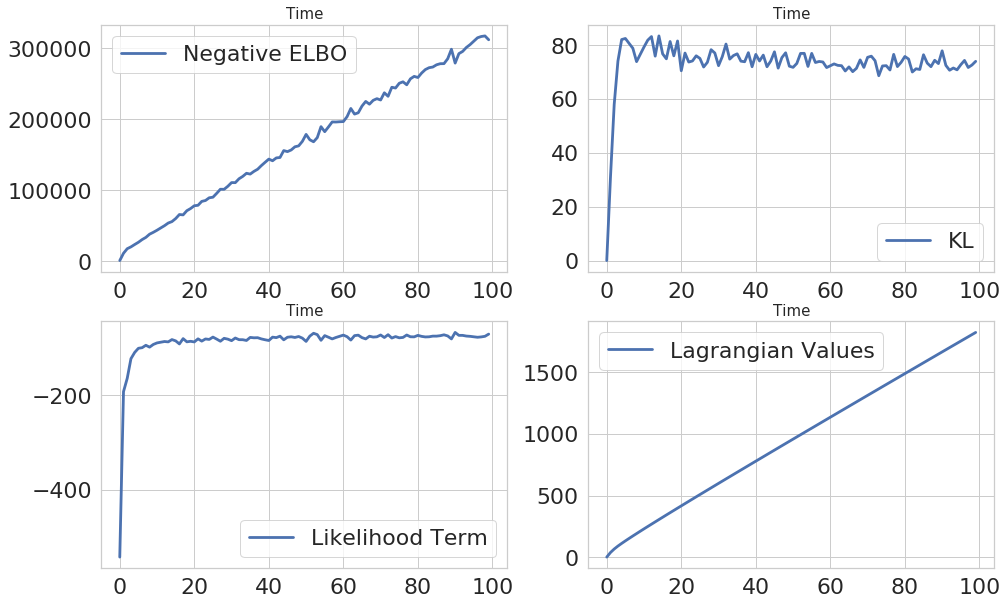

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(2*8, 2* 5))

axes[0, 0].plot(losses, label='Negative ELBO')
axes[0, 0].set_title('Time', fontsize=15)
axes[0, 0].legend()

axes[0, 1].plot(kls, label='KL')
axes[0, 1].set_title('Time', fontsize=15)
axes[0, 1].legend()

axes[1, 0].plot(likelihood_terms, label='Likelihood Term')
axes[1, 0].set_title('Time', fontsize=15)
axes[1, 0].legend()

axes[1, 1].plot(lagrangian_values, label='Lagrangian Values')
axes[1, 1].set_title('Time', fontsize=15)
axes[1, 1].legend()

In [0]:
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

### Generate samples and latent interpolations

In [0]:
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

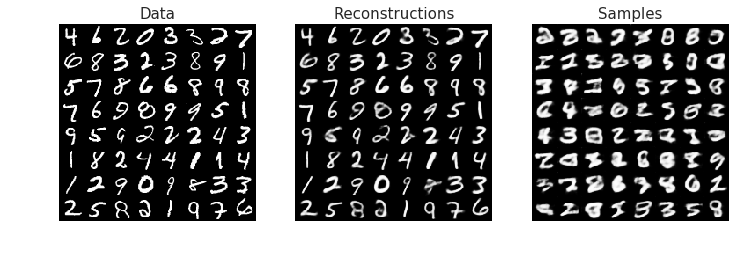

In [0]:
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

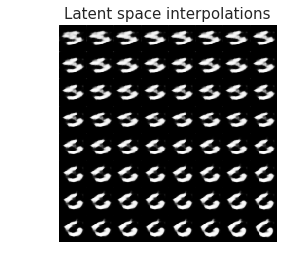

In [0]:
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q4.1 Questions about constrained optimization (12 pts)

1.  **[3 pts]** Based on previous results, set and try varying the threshold for reconstruction (variable `reconstruction_target` int the code above). Describe what happens when you vary this variable. (Produce the plots to support your answer)
2.  **[1 pts]** What do you observe about the behaviour of the likelihood and KL term throughout training? How is it different than in Stochastic Variational Inference and Amortized Variational inference with and without KL annealing?
3.  **[3 pts]** What do you notice about the behaviour of the lagrangian during training? Is that what you expected?


**[5 pts] Model Implementation and Results**

# Part 2: Reconstruction-free Generative Models

##  T2.1 Generative Adversarial Networks

So far we have discussed variational inference models, which learn how to match the marginal distribution $p_\theta(x)$, learned by the model, with the true data distribution $p^\star(x)$ through the variational lower bound. This approach uses latent variables and requires that the conditional posterior distributions cover the prior space; otherwise the decoder will not be able to generalise to prior samples which are unlike what it has seen during training. 


To avoid this issue, some methods directly match $p_\theta(x)$ learned by the model with the true data distribution $p^\star(x)$. Such an approach is given by generative adversarial networks (GANs).

Generative adversarial networks optimize an adversarial two-player game given by the value function:
\begin{equation}
\max_{G} \min_{D} \mathbb{E}_{p^*(x)} \log D(x) + \mathbb{E}_{p(z)} \log (1- D(G(z)))
\end{equation}
where $G$ is the generator (as before this takes a latent sample $z$ and produce a image $x_{gen}$) and $D$ denotes the discriminator. 

A depiction of the model can be found below:

<h2 align="center"></h2> <img src="http://elarosca.net/gan.png?format=100w" width=210 >

For more information, see: 
  * https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf
  * https://arxiv.org/abs/1701.00160

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.


## Q2.1 Prelimary questions (5 pts)

Before trying to implement this generative model, let us take a closer look at its components and how one can train them. 
*  **[2 pts]** First thing to note is that now we have two models to train: a generative model $G$ and a discriminative model $D$. How does one train these two models in the (standard) GAN formulation? Give the update rules and losses for each these ($D$ and $G$). Which of these losses uses the generated data and which of them uses the real data.

G loss is: minimise $\log (1- D(G(z)))$ and
D loss is : maximize $\log (D(x))$
*  **[3 pts]** [Generator loss] Instead of using the generator loss above, in practice we often use a surrogate,  $- \log D(G(x))$. Why do you think that is the case? Plot the original loss and associated gradients. Then plot the surgate loss $- \log D(G(x))$ and its associated gradients.

\begin{equation}
\max_{G} \min_{D} \mathbb{E}_{p^*(x)} \log D(x) + \mathbb{E}_{p(z)} \log (1- D(G(z)))
\end{equation}

may not provide sufficient gradient for G to learn well. Early in learning, G is poor which may allow D to reject samples easily (with high confidence). In this case $\log (1- D(G(z)))$ saturates. Thus we can get stronger gradients for learning G by instead trying to maximise $\log D(G(x))$, or equivalently, trying to minimise $- \log D(G(x))$.

## Model Implementation

In [0]:
tf.reset_default_graph()

### Get and rescale the data

Scale the data between -1 and 1. This helps training stability and improves GAN convergence.

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
real_data = 2 * real_data - 1

### Define the discriminator and generator networks

We will use the same network as the VAE decoder for the generator. The only difference is that the generator here is implicit - it does not define a probability distribution over pixels. Since the input data is scaled to be between -1, and 1, the generator output range will be the same, by using a tanh output non-linearty.

In [0]:
DISCRIMINATOR_VARIABLE_SCOPE = 'discriminator'
GENERATOR_VARIABLE_SCOPE = 'generator'

In [0]:
def discriminator(x):
  with tf.variable_scope(DISCRIMINATOR_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = x
    h = tf.layers.Conv2D(
          filters=8,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(x)
    h = tf.layers.Conv2D(
          filters=16,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=64,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=64,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h) 
    
    out_shape = 1
    for s in h.shape.as_list()[1:]:
      out_shape*= s
    
    h = tf.reshape(h, shape=[BATCH_SIZE, out_shape])
    logits = tf.layers.dense(h, 1, activation=None)
    return logits
    

In [0]:
def generator(z):
  with tf.variable_scope(GENERATOR_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = tf.layers.dense(z, 7 * 7 * 64, activation=tf.nn.relu)
    h = tf.reshape(h, shape=[BATCH_SIZE, 7, 7, 64])
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=1,
          kernel_size=5,
          strides=2,
          activation=None,  # Do not activate the last layer.
          padding='same')(h)
    return tf.nn.tanh(h)

## Generate samples

In [0]:
##################
# YOUR CODE HERE #
##################
prior = make_prior()
samples = prior.sample()

## Set up the adversarial game

### Discriminator loss

In [342]:
##################
# YOUR CODE HERE #
##################

G_z = generator(samples)
print(samples.shape)
print("Size of G_z: ", G_z.shape)

D_x = discriminator(real_data)
D_G_z = discriminator(G_z)

# Reduce loss over batch dimension
discriminator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_x, labels=tf.ones_like(D_x)) 
                                    + tf.nn.sigmoid_cross_entropy_with_logits(logits=(1-D_G_z), labels=tf.ones_like(D_G_z)))


(64, 10)
Size of G_z:  (64, 28, 28, 1)


### Generator loss

In [0]:
##################
# YOUR CODE HERE #
##################
generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_G_z, labels=tf.ones_like(D_G_z)))

### Create optimizers and training ops

**Important**: You will need to pass the list of variables to the TensorFlow optimizer, otherwise the generator and discriminator
variables will receive both the loss of the discrimiantor and that of the generator. 

We want to freeze the discriminator when we update the generator, and vice versa.

In [0]:
discriminator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)
generator_optimizer = tf.train.AdamOptimizer(0.0003, beta1=0.9, beta2=0.9)

# Optimize the discrimiantor.
discriminator_vars =  tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=DISCRIMINATOR_VARIABLE_SCOPE)
discriminator_update_op = discriminator_optimizer.minimize(discriminator_loss, var_list=discriminator_vars)

# Optimize the generator.
generator_vars =  tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=GENERATOR_VARIABLE_SCOPE)
generator_update_op = generator_optimizer.minimize(generator_loss, var_list=generator_vars)

## Training


### Create the tensorflow session

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

### Training Loop

We train the discriminator and generator by alternating gradient descent runs. We record the losses to plot them later.

In [346]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
disc_losses = []
gen_losses = []

for i in xrange(TRAINING_STEPS):
  sess.run(discriminator_update_op)
  sess.run(generator_update_op)
  
  if i % 100 == 0: 
    disc_loss = sess.run(discriminator_loss)
    gen_loss = sess.run(generator_loss)
    
    print('Iteration: {}. Disc loss: {}. Generator loss {}'.format(
          i, disc_loss, gen_loss))
  
    disc_losses.append(disc_loss)
    gen_losses.append(gen_loss)

Iteration: 0. Disc loss: 0.99178057909. Generator loss 0.692864239216
Iteration: 100. Disc loss: 0.067670866847. Generator loss 1.84010100365
Iteration: 200. Disc loss: 0.0132937263697. Generator loss 3.77677750587
Iteration: 300. Disc loss: 0.0962735936046. Generator loss 3.63217973709
Iteration: 400. Disc loss: 0.000105959814391. Generator loss 8.30920600891
Iteration: 500. Disc loss: 1.40209579058e-06. Generator loss 12.5844116211
Iteration: 600. Disc loss: 0.162595942616. Generator loss 2.42212057114
Iteration: 700. Disc loss: 0.0481645390391. Generator loss 3.89645910263
Iteration: 800. Disc loss: 0.0159924477339. Generator loss 3.71327447891
Iteration: 900. Disc loss: 0.0810789912939. Generator loss 1.90463459492
Iteration: 1000. Disc loss: 0.224207416177. Generator loss 1.41608428955
Iteration: 1100. Disc loss: 0.587138056755. Generator loss 0.413238823414
Iteration: 1200. Disc loss: 0.957574009895. Generator loss 0.27478942275
Iteration: 1300. Disc loss: 0.961032390594. Generat

## Results

### Visualize the behaviour of the two losses during training

Note that unlike losses for classifiers, or for VAEs, the losses are not stable and are going up and down, depending on the training dynamics. 

Text(0.5,-0.2,'Generator loss')

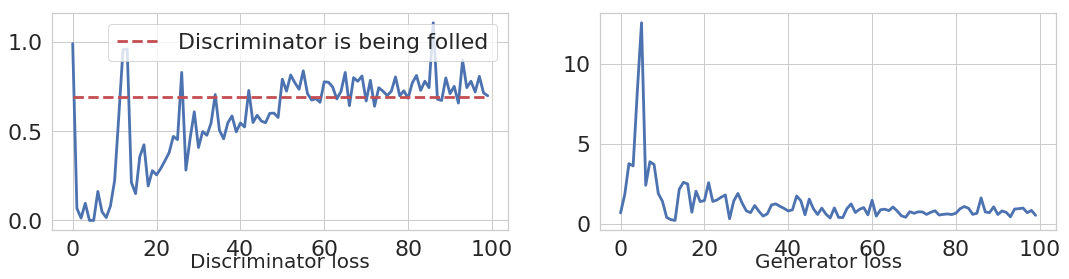

In [347]:
figsize = (18, 4)
fig, axs = plt.subplots(1, 2, figsize=figsize)


# First plot the loss, and then the derivative.
axs[0].plot(disc_losses, '-')
axs[0].plot([np.log(2)] * len(disc_losses), 'r--', label='Discriminator is being folled')
axs[0].legend()
axs[0].set_title('Discriminator loss', fontsize=20, y=-0.2)
axs[1].plot(gen_losses, '-')
axs[1].set_title('Generator loss', fontsize=20, y=-0.2)

### Generate and plot samples and latent interpolations

In [348]:
real_data_vals, final_samples_vals  = sess.run([real_data, generator(samples)])
print(real_data_vals.shape)
print(final_samples_vals.shape)

(64, 28, 28, 1)
(64, 28, 28, 1)


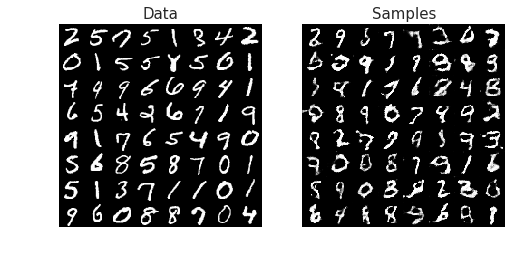

In [349]:
fig, axes = plt.subplots(1, 2, figsize=(2*4,4))

show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], final_samples_vals, 'Samples')

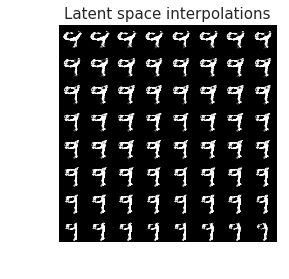

In [350]:
show_latent_interpolations(generator, prior, sess)

## Q2.2 GAN Questions (25 pts):  
1.  **[3 pts]** In defining the optimization procedure above (Section **Create optimizers and training ops**) we opted for two optimizer one for the discriminator and one for the generator. Is this necessary? Why would this be a good/bad idea in general? 

Although the minmax cost function has the same fixed point dynamics for G and D, D has much larger gradients in early learning and thus it is appropriate to have a different setting of hyperparameters for learning within the optimizer, for example with a smaller learning rate for D.

2.  **[3 pts]** Discuss the hyperparameter sensitivy of GANs compared to that of VAEs. (What happens to the model if you use a higher learning rate for the discriminator or the generator?)

3.  **[2 pts]** When would you want to use GANs and when would you want to use VAEs? Which of the following can be performed using VAEs, and which can be performed using GANs: density estimation, representation learning, data generation?
4.  **[2 pts]** What do you observe about GAN samples compared to VAE samples?
5.  **[3 pts]** What happens if you optimize the GAN discriminator 5 times per generator update? (This will become particularly relevant for next part) 
6.  **[2 pts]** What happens if you optimize the GAN generator 10 times per discriminator update?

**[10 pts] Model Implementation and Results**


# ===== END OF GRADED COURSEWORK ========

## T2.2 [Optional] Wasserstein GAN

Since the proposal of the original GAN, multiple objectives have been proposed, inspired by different learning principles. In Wasserstein GAN, optimal transport is used to create the training criteria:
\begin{equation}
  \sup_{||f||_{L \leq 1}} \mathbb{E}_{p^*(x)} f(x) - \mathbb{E}_{p_(z)} f(G(z))
\end{equation}
where $||f||_{L \leq 1}$ denotes the family of 1-Lipchitz functions.

Due to the intractability of the supremum in the equation above, the WGAN value function is constructed from the optimal transport criteria using the Kantorovich-Rubinstein duality:
\begin{equation}
  \min_{G} \max_{D}  \mathbb{E}_{p^*(x)} D(x) - \mathbb{E}_{p_(z)} D(G(z))
\end{equation}

where $D$ is a 1-Lipchitz function. The Lipchitz constraint is imposed using gradient penalties on the discriminator. 

For extra reading, see:
 * https://arxiv.org/abs/1701.07875
 * https://arxiv.org/abs/1704.00028


**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

### Define the gradient penalty

In [0]:
def batch_l2_norms(x, eps=1e-5):
  reduction_axis = range(1, x.get_shape().ndims)
  squares = tf.reduce_sum(tf.square(x), axis=reduction_axis)
  squares.get_shape().assert_is_compatible_with([None])
  return tf.sqrt(eps + squares)

def wgan_gradient_penalty(discriminator, real_data, samples):
  """The gradient penalty loss on an interpolation of data and samples.

  Proposed by https://arxiv.org/pdf/1704.00028.pdf for Wasserstein GAN, but
  recently becoming more widely adopted, outside the Wasserstein setting.

  Args:
    discriminator: An instance of `AbstractDiscriminator`.
    real_data: A `tf.Tensor` (joint discriminator `tf.Tensor` sequences are not
      yet supported). The data associated as real by the GAN, usually from a
      datasets. Needs to be a valid input for `discriminator`.
    samples: A `tf.Tensor` or `tf.Tensor` sequence (for joint discriminators).
      Samples obtained from the model. Needs to be a valid input for
      `discriminator`.

  Returns:
    A `tf.Tensor` scalar, containing the loss.
  """

  ##################
  # YOUR CODE HERE #
  ##################

### Get and rescale the data

Scale the data between -1 and 1. This helps training stability and improves GAN convergence.

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
real_data = 2 * real_data - 1

### Generate samples

In [0]:
##################
# YOUR CODE HERE #
##################
# samples = 

## Set up the adversarial game

### Discriminator and generator loss

In [0]:
# The weight of the gradient penalty
GRADIENT_PENALTY_COEFF = 10

In [0]:
##################
# YOUR CODE HERE #
##################
# discriminator_loss = 
# generator_loss = 

### Create optimizers and training ops



In [0]:
discrimiantor_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)
generator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)

# Optimize the discrimiantor.
discriminator_vars =  tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DISCRIMINATOR_VARIABLE_SCOPE)
discriminator_update_op = discrimiantor_optimizer.minimize(
    discriminator_loss, var_list=discriminator_vars)

# Optimize the generator.
generator_vars =  tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=GENERATOR_VARIABLE_SCOPE)
generator_update_op = generator_optimizer.minimize(
    generator_loss, var_list=generator_vars)

## Training

We train the discriminator and generator by alternating gradient descent runs. We record the losses to plot them later.

### Create the tensorflow session

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

In [0]:
NUM_DISC_UPDATES_PER_GEN_UPDATE = 5

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
disc_losses = []
gen_losses = []

for i in xrange(TRAINING_STEPS):
  # Do multiple discriminator updates per generator update. 
  for _ in xrange(NUM_DISC_UPDATES_PER_GEN_UPDATE):
    sess.run(discriminator_update_op)
  sess.run(generator_update_op)
  
  if i % 100 == 0: 
    disc_loss = sess.run(discriminator_loss)
    gen_loss = sess.run(generator_loss)    
  
    print('Iteration: {}. Disc loss: {}. Generator loss {}'.format(
          i, disc_loss, gen_loss))
    disc_losses.append(disc_loss)
    gen_losses.append(gen_loss)

## Results

### Visualize the behaviour of the two losses during training

Note that unlike losses for classifiers, or for VAEs, the losses are not stable and are going up and down, depending on the training dynamics. 

In [0]:
figsize = (20, 6)
fig, axs = plt.subplots(1, 2, figsize=figsize)


# First plot the loss, and then the derivative.
axs[0].plot(disc_losses, '-')
axs[0].plot([0.] * len(disc_losses), 'r--', label='Discriminator is being folled')
axs[0].legend()
axs[0].set_title('Discriminator loss', fontsize=20, y=-0.2)
axs[1].plot(gen_losses, '-')
axs[1].set_title('Generator loss', fontsize=20, y=-0.2)

### Generate samples and latent interpolations

In [0]:
real_data_vals, final_samples_vals  = sess.run([real_data, samples])

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(2*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], final_samples_vals, 'Samples')

In [0]:
show_latent_interpolations(generator, prior, sess)

## Questions about WGANs:

* What happens if you optimize the original GAN discriminator 5 times per generator update - like in Wasserstein GANs? What happens if you train the Wassterstein GAN with 1 discriminator update per generator update?
* Can you think of a general recipe to create a new type of GAN loss?
